In [1]:
pip install scikit-learn-extra

Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import ScalarMappable
from scipy.cluster.hierarchy import linkage, dendrogram,fcluster
from sklearn.preprocessing import normalize
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

/Users/floyd/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [21]:
data_dir = "crocker_results"
file_list = sorted([f for f in os.listdir(data_dir) if f.endswith(".npy")])
vectorized_data = []

for fname in file_list:
    matrix = np.load(os.path.join(data_dir, fname))
    vector = matrix.flatten()
    
    # Normalize the vector using L2 norm
    norm_vector = normalize(vector.reshape(1, -1), norm='l2')[0]
    vectorized_data.append(norm_vector)

X = np.vstack(vectorized_data)
print("Shape of X:", X.shape)

Shape of X: (100, 16320)


In [4]:
filenames = [os.path.splitext(f)[0] for f in file_list]

In [22]:
#K-mean
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

cluster_df = pd.DataFrame({
    'field': filenames,
    'cluster': labels
})

print(cluster_df.head())
print(cluster_df.sort_values(by='cluster'))

                                    field  cluster
0  Accounting Auditing and Accountability        5
1                   Aerospace Engineering        5
2              Agricultural Biotechnology        7
3    Agriculture Land and Farm Management        0
4                    Analytical Chemistry        1
                                       field  cluster
34            Design Practice and Management        0
27                         Computer Hardware        0
36                   Ecological Applications        0
23           Communication and Media Studies        0
21                         Classical Physics        0
..                                       ...      ...
83         Other Medical and Health Sciences        7
82  Other Information and Computing Sciences        7
2                 Agricultural Biotechnology        7
41               Environmental Biotechnology        7
35                     Distributed Computing        7

[100 rows x 2 columns]


In [23]:
pca = PCA(n_components=2, random_state=2)
X_2d = pca.fit_transform(X) 

/var/folders/v9/_js75nzx64lf8__fmfsscg4c0000gn/T/ipykernel_2999/3535064491.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=range(n_clusters))


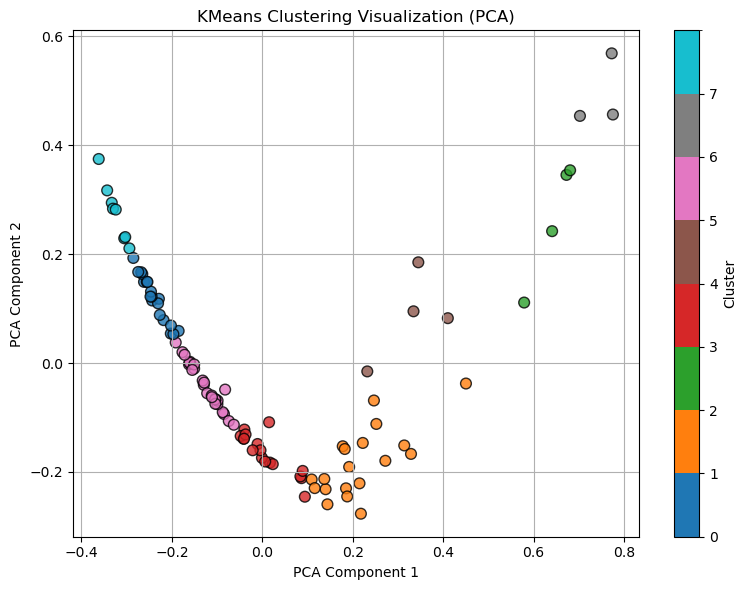

In [25]:
cmap = plt.get_cmap('tab10')
norm = BoundaryNorm(boundaries=range(n_clusters+1), ncolors=cmap.N)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=labels,
    cmap=cmap,
    norm=norm,
    s=60,
    alpha=0.8,
    edgecolor='k'
)

# colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # dummy array
cbar = plt.colorbar(sm, ticks=range(n_clusters))
cbar.set_label('Cluster')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans Clustering Visualization (PCA)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
testgroup = 6
cluster_fields = cluster_df[cluster_df['cluster'] == testgroup]
cluster_fields

,field,cluster
7,Applied Economics,6
15,Biochemistry and Cell Biology,6
43,Environmental Science and Management,6


In [38]:
betti_matrices_subfield = {}

for field in cluster_fields['field']:
    var_name = field.lower().replace(" ", "_").replace("&", "and")
    
    filepath = os.path.join(data_dir, f"{field}.npy")
    betti_matrices_subfield[var_name] = np.load(filepath)

In [39]:
years = np.linspace(0, 1, 102).tolist()
inv_counts = 1 / np.arange(40, 0, -1)

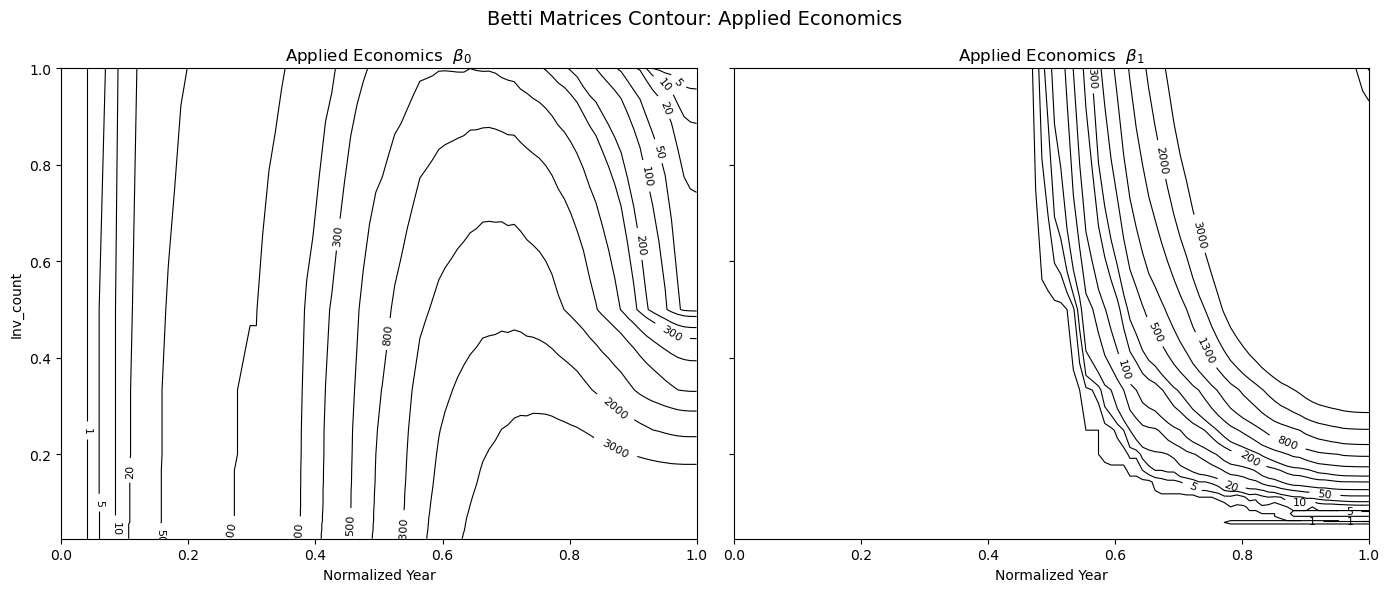

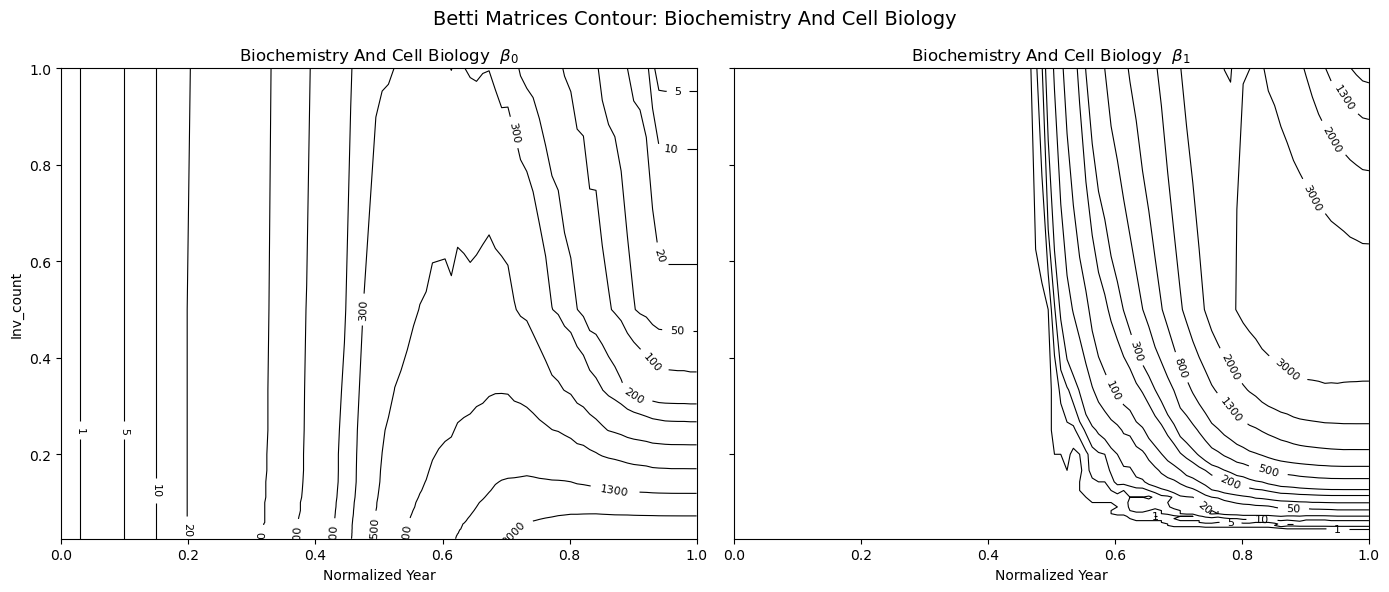

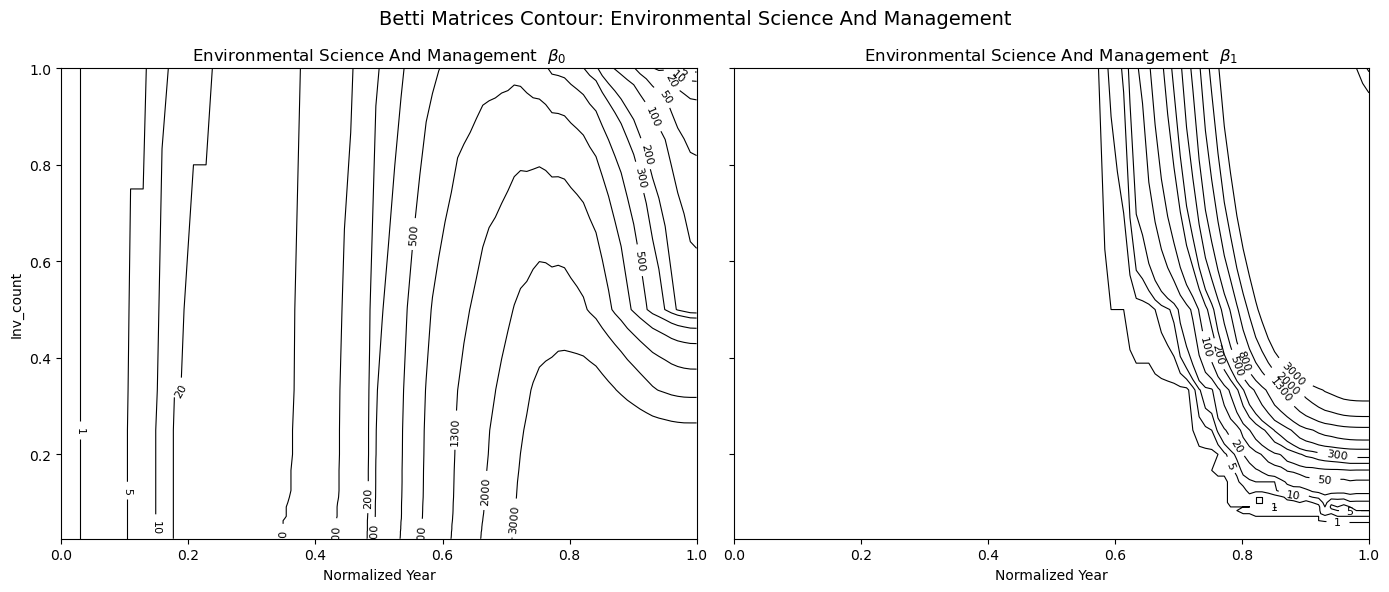

In [40]:
X1, Y = np.meshgrid(years, inv_counts)

levels = [1, 5, 10, 20, 50, 100, 200, 300, 500, 800, 1300, 2000, 3000]

for name, matrix in betti_matrices_subfield.items():
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    
    for dim, ax in enumerate(axs):
        Z = matrix[:, :, dim].T
        cp = ax.contour(X1, Y, Z, levels=levels, colors='black', linewidths=0.8)
        ax.clabel(cp, inline=True, fontsize=8)
        ax.set_xlabel("Normalized Year")
        ax.set_title(f"{name.replace('_', ' ').title()}  $\\beta_{dim}$")
    
    axs[0].set_ylabel("Inv_count")
    plt.suptitle(f"Betti Matrices Contour: {name.replace('_', ' ').title()}", fontsize=14)
    plt.tight_layout()
    plt.show()